In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

In [2]:
# @param X: pandas.DataFrame
# @param featureSel: int
# @return X: pandas.DataFrame
def featureEng(X, featureSel=None):
    # Feature Engineering
    if not featureSel or featureSel == 0:
        return X
    if featureSel == 1:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
    elif featureSel == 2:
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 3:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 4:
        attriToDrop = [
            'FGM_A', 'FGA_A', '3PM_A', '3PA_A', 'FTM_A', 'FTA_A', 'OREB_A', 'DREB_A', 'PF_A', 
            'FGM_B', 'FGA_B', '3PM_B', '3PA_B', 'FTM_B', 'FTA_B', 'OREB_B', 'DREB_B', 'PF_B'
        ]
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        X['STL+BLK_A'] = X['STL_A'] + X['BLK_A']
        X['STL+BLK_B'] = X['STL_B'] + X['BLK_B']
        attriToDrop += ['PTS_A', 'PTS_B', 'STL_A', 'STL_B', 'BLK_A', 'BLK_B']
        X = X.drop(columns=attriToDrop)
    return X

In [3]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# featureExtraction() outputs X, Y for model training.
def featureExtraction(dfFile, dateStart='1000-01-01', dateEnd='2999-12-31', period=5, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selection
    df = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Get label Y
    Y = df[['W/L_A']]
    Y = Y.rename(columns={'W/L_A': 'Label'})
    
    # Get averaged attributes X
    for idx, row in df.iterrows():
        df_sel = df.loc[df.Date_A <= row['Date_A'], :].reset_index(drop=True)
        
        # Process of Team_A
        gamePlayed_A = df_sel.loc[df_sel.Team_A == row['Team_A'], :]
        if len(gamePlayed_A) == 1:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_A) < period:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_A), 0:24].reset_index(drop=True)
        else:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Process of Team_B
        gamePlayed_B = df_sel.loc[df_sel.Team_A == row['Team_B'], :]
        if len(gamePlayed_B) == 1:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_B) < period:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_B), 0:24].reset_index(drop=True)
        else:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Drop unnecessary attributes
        colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
        X_A = X_A.drop(columns=colToDrop)
        X_B = X_B.drop(columns=colToDrop)
        
        # Rename X_B's columns
        X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
        
        # Get X_single = [Home/Away_A + X_A + X_B]
        X_single = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
        X_single = pd.concat([pd.DataFrame(data={'Home/Away_A': [row['Home/Away_A']]}), X_single], axis=1)
        
        # Concatenation dataFrames by row
        if idx == 0:
            X = X_single
        else:
            X = pd.concat([X, X_single], ignore_index=True)
        
    # Feature Engineering
    X = featureEng(X, featureSel)
        
    return X, Y

In [4]:
# Feature Extraction
dfFile = './nba_preprocessed.csv'
dateStart = '2017-08-01'
dateEnd = '2018-04-13'
period = 5
featureSel = 3
X, Y = featureExtraction(dfFile, dateStart, dateEnd, period, featureSel)
X.head()

,Home/Away_A,FG%_A,FGM_A,FGA_A,3P%_A,3PM_A,3PA_A,FT%_A,FTM_A,FTA_A,...,FTA_B,REB_B,OREB_B,DREB_B,AST_B,STL_B,BLK_B,TOV_B,PF_B,PTS_DIFF
0,0,0.468000,36.000000,77.000000,0.481000,13.000000,27.000000,0.917000,11.000000,12.000000,...,16.000000,36.000000,6.000000,30.000000,28.000000,9.0,5.0,15.000000,18.0,-10.00
1,1,0.468000,36.000000,77.000000,0.481000,13.000000,27.000000,0.917000,11.000000,12.000000,...,11.500000,49.500000,12.500000,37.000000,19.500000,6.5,3.5,15.500000,19.0,-0.50
2,1,0.451500,36.500000,81.000000,0.407000,11.500000,28.500000,0.758500,11.500000,16.000000,...,36.500000,44.500000,11.500000,33.000000,23.000000,10.0,8.5,12.500000,19.0,-21.50
3,0,0.463667,37.333333,80.666667,0.387333,10.333333,26.666667,0.766667,13.666667,18.333333,...,31.666667,50.666667,8.333333,42.333333,16.666667,4.0,4.0,17.333333,18.0,1.00
4,0,0.443750,37.500000,85.250000,0.355000,9.750000,27.750000,0.725000,12.500000,17.500000,...,19.200000,43.400000,9.800000,33.600000,19.200000,9.4,3.6,14.400000,22.4,-0.95


In [5]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str
# @param homeAway: int (None for played game prediction)
# @param featureSel: int
# @return X: pandas.DataFrame
def attriGen(df, date, period, Team_A, Team_B, homeAway=None, featureSel=None):
    # True Home/Away at the game day
    if homeAway is None:
        df_gameDay = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)
        homeAway = int(df_gameDay['Home/Away_A'])
    
    # Date selections
    df = df.loc[df.Date_A < date, :].reset_index(drop=True)
    X_A = df.loc[(df.Team_A == Team_A), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    X_B = df.loc[(df.Team_A == Team_B), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    
    # Drop unnecessary attributes
    colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
    X_A = X_A.drop(columns=colToDrop)
    X_B = X_B.drop(columns=colToDrop)
    
    # Rename X_away's columns
    X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
    
    # Get X = [Home/Away_A + X_A + X_B]
    X = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
    X = pd.concat([pd.DataFrame(data={'Home/Away_A': [homeAway]}), X], axis=1)
    
    # Feature Engineering
    X = featureEng(X, featureSel)
    
    return X

In [6]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param Team_A, Team_B: str
# @param featureSel: int
# @return X_groundTruth, Y_groundTruth: pandas.DataFrame
def groundTruthGen(df, date, Team_A, Team_B, featureSel=None):
    # Date selections
    df = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)

    # Get label Y
    Y_groundTruth = df[['W/L_A']]
    Y_groundTruth = Y_groundTruth.rename(columns={'W/L_A': 'Label'})
    
    # Drop unnecessary attributes
    colToDrop = [
        'Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A', 
        'Team_B', 'Date_B', 'W/L_B', 'Home/Away_B', 'Score_B', 'Opponent_B'
    ]
    X_groundTruth = df.drop(columns=colToDrop)
    
    # Feature Engineering
    X_groundTruth = featureEng(X_groundTruth, featureSel)
    
    return X_groundTruth, Y_groundTruth

In [7]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# gameAttriGen() outputs X_attri, Y_truth for game prediction.
def gameAttriGen(dfFile, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selections
    df_sel = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Generate df_sel which includes [date, Team_A, Team_B] columns
    if Team_A and Team_B:
        df_sel = df_sel.loc[(df_sel.Team_A == Team_A) & (df_sel.Opponent_A == Team_B), :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif Team_A and not Team_B:
        df_sel = df_sel.loc[df_sel.Team_A == Team_A, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and Team_B:
        df_sel = df_sel.loc[df_sel.Opponent_A == Team_B, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and not Team_B:
        df_sel = df_sel[['Date_A', 'Team_A', 'Opponent_A']]
        # Delete duplicates: (Team_A vs Team_B) is the same as (Team_B vs Team_A). Remove one to avoid double count.
        df_new = pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'])
        LUT = {}
        for date, x, y in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
            if (date + x + y) in LUT:
                df_new = pd.concat([df_new, pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'], data=[[date, x, y]])], ignore_index=True)
            else:
                LUT[date + x + y] = 1
                LUT[date + y + x] = 1
        df_sel = df_new
    
    # W/L prediction
    X_attri = Y_truth = None
    for date, Team_A, Team_B in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
        X_toBePredicted = attriGen(df, date, period, Team_A, Team_B, None, featureSel)
        X_groundTruth, Y_groundTruth = groundTruthGen(df, date, Team_A, Team_B, featureSel)
        if X_attri is None and Y_truth is None:
            X_attri = X_toBePredicted
            Y_truth = Y_groundTruth
        else:
            X_attri = pd.concat([X_attri, X_toBePredicted], ignore_index=True)
            Y_truth = pd.concat([Y_truth, Y_groundTruth], ignore_index=True)
        
    return X_attri, Y_truth

In [8]:
from sklearn.metrics import accuracy_score
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param modelsLUT: dict in the format of {'modelName': model}
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return None
# gamePrediction() prints the predicted game W/L results.
def gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None, is_print_result=0):
    X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
    
    resultLUT, accuLUT = {}, {}
    for model in modelsLUT:
        resultLUT[model] = modelsLUT[model].predict(X_attri)
        #accuLUT[model] = accuracy_score(Y_truth, modelsLUT[model].predict(X_attri))
        accuLUT[model] = accuracy_score(Y_truth, resultLUT[model])
    
    if(is_print_result):
        print('---------- Prediction Accuracy ----------')
        print('featureSel =', featureSel)
        for x in accuLUT:
            print(x, '=', accuLUT[x]*100, '%')
        print('------------------------------------')
    return accuLUT

In [9]:
# Model Training
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

logiRegr = LogisticRegression()
logiRegr.fit(X, Y.values.ravel())

supVecMachine = SVC(kernel='linear', probability=True)
supVecMachine.fit(X, Y.values.ravel())

xgbc = xgb.XGBClassifier()
xgbc.fit(X, Y)

naiveBayes = GaussianNB()
naiveBayes.fit(X, Y.values.ravel())

randomForest = RandomForestClassifier()
randomForest.fit(X, Y.values.ravel())

gbdt = GradientBoostingClassifier()
gbdt.fit(X,Y.values.ravel())

lgbm = LGBMClassifier()
lgbm.fit(X, Y.values.ravel())

adaBoost = AdaBoostClassifier()
adaBoost.fit(X, Y.values.ravel())

# Prediction
dateStart = '2018-04-14'
dateEnd = '2018-06-01'
Team_A = None
Team_B = None
modelsLUT = {
    'logiRegr': logiRegr,
    'supVecMachine': supVecMachine,
    'xgbc': xgbc,
    'naiveBayes': naiveBayes,
    'randomForest': randomForest,
    'gbdt': gbdt,
    'lgbm': lgbm, 
    'adaBoost': adaBoost
}

# W/L prediction
gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel, 1)

---------- Prediction Accuracy ----------
featureSel = 3
logiRegr = 69.62025316455697 %
supVecMachine = 70.88607594936708 %
xgbc = 74.68354430379746 %
naiveBayes = 60.75949367088608 %
randomForest = 60.75949367088608 %
gbdt = 72.15189873417721 %
lgbm = 68.35443037974683 %
adaBoost = 68.35443037974683 %
------------------------------------


{'adaBoost': 0.6835443037974683,
 'gbdt': 0.7215189873417721,
 'lgbm': 0.6835443037974683,
 'logiRegr': 0.6962025316455697,
 'naiveBayes': 0.6075949367088608,
 'randomForest': 0.6075949367088608,
 'supVecMachine': 0.7088607594936709,
 'xgbc': 0.7468354430379747}

## Parameter Search

In [10]:
def ParameterSearch(X=None, Y=None, dateStart='2018-04-14', dateEnd='2018-06-01', Team_A=None, Team_B=None, 
                    param_name=None, param_list=None, model=None, title=None, **other_setting):
    total_acc = []
    max_acc = -1
    max_param_val = -1
    total_len = len(param_list)
    count_prog = 0
    for val in param_list:
        other_setting[param_name] = val
        model.set_params(**other_setting)
        model.fit(X, Y.values.ravel())
    
        modelsLUT = {
            'model': model
        }
        ret_acc = gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel, 0)
    
        for model_name in modelsLUT:
            total_acc.append(ret_acc[model_name])
            if(total_acc[-1] > max_acc):
                max_acc = total_acc[-1]
                max_param_val = val
        count_prog += 1
        print('Progress = {x}%'.format(x = count_prog/total_len*100))
    
    print(f'max_acc = {max_acc}, with {param_name} = {max_param_val}')
    plt.plot(param_list, total_acc)
    plt.xlabel(f' {title} ')
    plt.ylabel(' Accuracy ')
    plt.show()  

### Logistic Regressor

Progress = 2.5%
Progress = 5.0%
Progress = 7.5%
Progress = 10.0%
Progress = 12.5%
Progress = 15.0%
Progress = 17.5%
Progress = 20.0%
Progress = 22.5%
Progress = 25.0%
Progress = 27.500000000000004%
Progress = 30.0%
Progress = 32.5%
Progress = 35.0%
Progress = 37.5%
Progress = 40.0%
Progress = 42.5%
Progress = 45.0%
Progress = 47.5%
Progress = 50.0%
Progress = 52.5%
Progress = 55.00000000000001%
Progress = 57.49999999999999%
Progress = 60.0%
Progress = 62.5%
Progress = 65.0%
Progress = 67.5%
Progress = 70.0%
Progress = 72.5%
Progress = 75.0%
Progress = 77.5%
Progress = 80.0%
Progress = 82.5%
Progress = 85.0%
Progress = 87.5%
Progress = 90.0%
Progress = 92.5%
Progress = 95.0%
Progress = 97.5%
Progress = 100.0%
max_acc = 0.6962025316455697, with C = 0.11


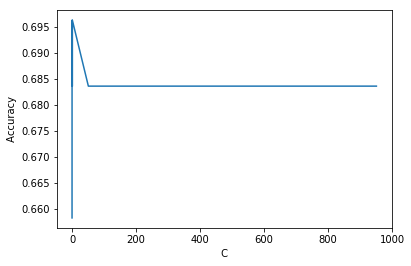

In [13]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[x/100 for x in range(1, 100, 5)]+[x for x in range(1, 1000, 50)], model=LogisticRegression()
                , title = 'C', max_iter=300)

Progress = 3.3333333333333335%
Progress = 6.666666666666667%
Progress = 10.0%
Progress = 13.333333333333334%
Progress = 16.666666666666664%
Progress = 20.0%
Progress = 23.333333333333332%
Progress = 26.666666666666668%
Progress = 30.0%
Progress = 33.33333333333333%
Progress = 36.666666666666664%
Progress = 40.0%
Progress = 43.333333333333336%
Progress = 46.666666666666664%
Progress = 50.0%
Progress = 53.333333333333336%
Progress = 56.666666666666664%
Progress = 60.0%
Progress = 63.33333333333333%
Progress = 66.66666666666666%
Progress = 70.0%
Progress = 73.33333333333333%
Progress = 76.66666666666667%
Progress = 80.0%
Progress = 83.33333333333334%
Progress = 86.66666666666667%
Progress = 90.0%
Progress = 93.33333333333333%
Progress = 96.66666666666667%
Progress = 100.0%
max_acc = 0.6962025316455697, with C = 0.11


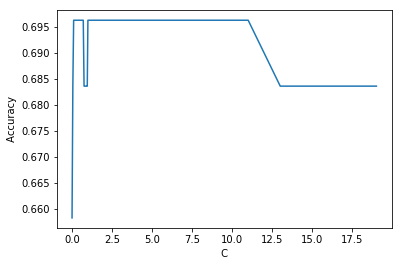

In [17]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[x/100 for x in range(1, 100, 5)]+[x for x in range(1, 20, 2)], model=LogisticRegression()
                , title = 'C', max_iter=300)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6962025316455697, with max_iter = 10


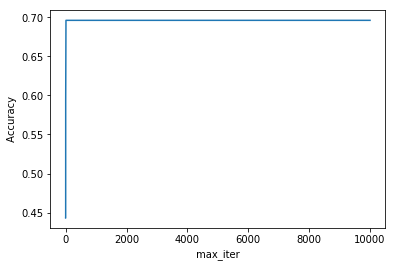

In [15]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_iter'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=LogisticRegression()
                , title = 'max_iter', C=0.11)

Progress = 10.0%
Progress = 20.0%
Progress = 30.0%
Progress = 40.0%
Progress = 50.0%
Progress = 60.0%
Progress = 70.0%
Progress = 80.0%
Progress = 90.0%
Progress = 100.0%
max_acc = 0.6962025316455697, with max_iter = 6


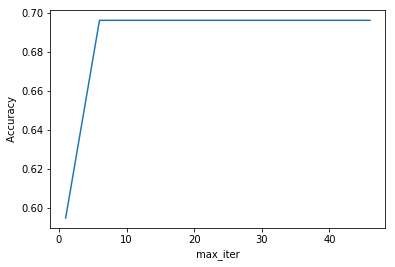

In [18]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_iter'
                , param_list=range(1, 50, 5), model=LogisticRegression()
                , title = 'max_iter', C=0.11)

### Result : C=0.11, max_iter = 6

### SVM

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.759493670886076, with C = 10000


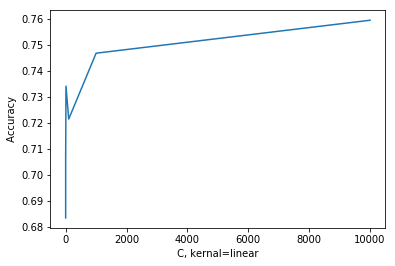

In [16]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=linear', kernel='linear', probability=True)

Progress = 25.0%
Progress = 50.0%
Progress = 75.0%
Progress = 100.0%
max_acc = 0.759493670886076, with C = 10000


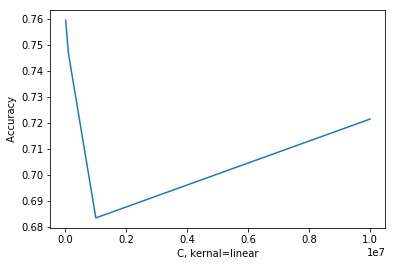

In [19]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[10000, 100000, 1000000, 10000000], model=SVC()
                , title='C, kernal=linear', kernel='linear', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.5569620253164557, with C = 1


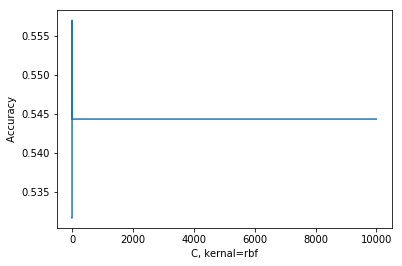

In [11]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=rbf', kernel='rbf', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6075949367088608, with gamma = 1


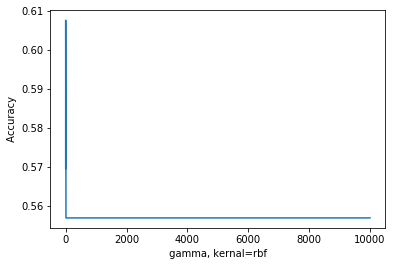

In [12]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='gamma'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='gamma, kernal=rbf', C=1, kernel='rbf', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6075949367088608, with C = 0.01


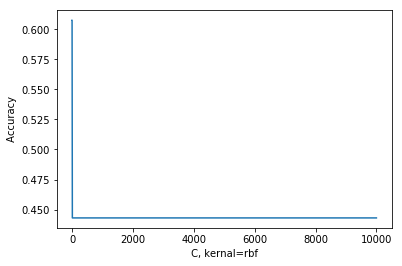

In [13]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=rbf', gamma=1, kernel='rbf', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6075949367088608, with gamma = 1


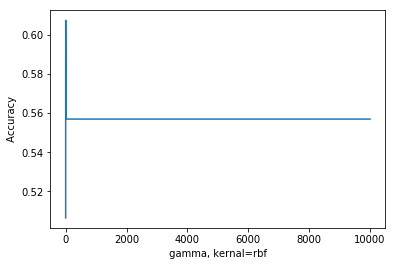

In [14]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='gamma'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='gamma, kernal=rbf', C=0.01, kernel='rbf', probability=True)

### Result : C=10000, kernal = 'linear'

### XGBClassifier

Progress = 6.25%
Progress = 12.5%
Progress = 18.75%
Progress = 25.0%
Progress = 31.25%
Progress = 37.5%
Progress = 43.75%
Progress = 50.0%
Progress = 56.25%
Progress = 62.5%
Progress = 68.75%
Progress = 75.0%
Progress = 81.25%
Progress = 87.5%
Progress = 93.75%
Progress = 100.0%
max_acc = 0.7468354430379747, with max_depth = 3


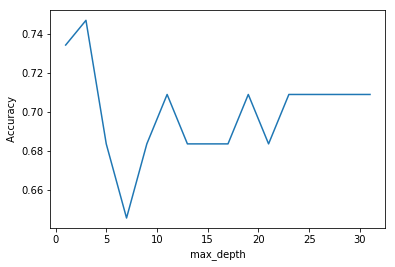

In [18]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.1, n_estimators=100)

Progress = 16.666666666666664%
Progress = 33.33333333333333%
Progress = 50.0%
Progress = 66.66666666666666%
Progress = 83.33333333333334%
Progress = 100.0%
max_acc = 0.7468354430379747, with learning_rate = 0.1


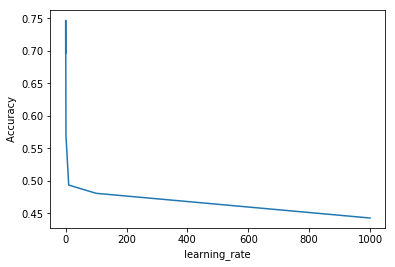

In [20]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000], model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=3, n_estimators=100)

Progress = 16.666666666666664%
Progress = 33.33333333333333%
Progress = 50.0%
Progress = 66.66666666666666%
Progress = 83.33333333333334%
Progress = 100.0%
max_acc = 0.759493670886076, with n_estimators = 1


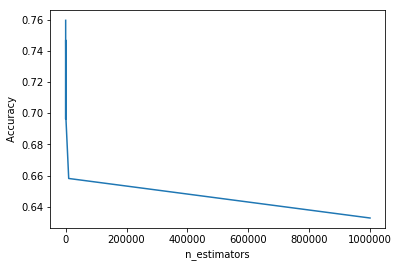

In [21]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000, 1000000], model=xgb.XGBClassifier()
                , title='n_estimators', max_depth=3, learning_rate=0.1)

Progress = 6.25%
Progress = 12.5%
Progress = 18.75%
Progress = 25.0%
Progress = 31.25%
Progress = 37.5%
Progress = 43.75%
Progress = 50.0%
Progress = 56.25%
Progress = 62.5%
Progress = 68.75%
Progress = 75.0%
Progress = 81.25%
Progress = 87.5%
Progress = 93.75%
Progress = 100.0%
max_acc = 0.759493670886076, with max_depth = 3


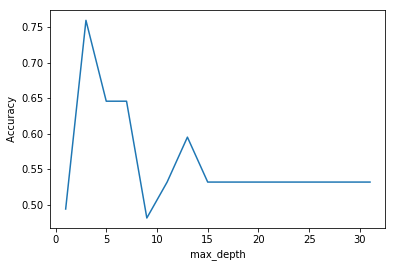

In [22]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.1, n_estimators=1)

Progress = 16.666666666666664%
Progress = 33.33333333333333%
Progress = 50.0%
Progress = 66.66666666666666%
Progress = 83.33333333333334%
Progress = 100.0%
max_acc = 0.759493670886076, with learning_rate = 0.01


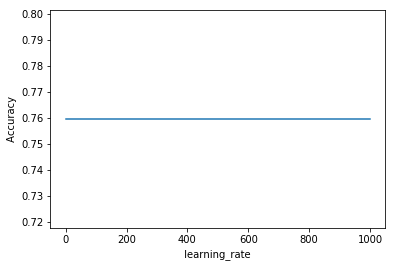

In [23]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000], model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=3, n_estimators=1)

### Result : max_depth = 3,  learning_rate = 0.1, n_estimators=1

### RandomForestClassifier

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7215189873417721, with n_estimators = 1


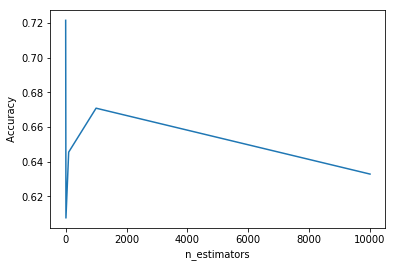

In [25]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='entropy', max_depth=3)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.620253164556962, with max_depth = 100


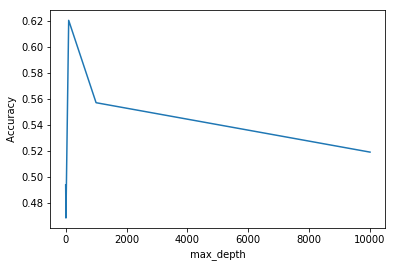

In [26]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='max_depth', criterion='entropy', n_estimators=1)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6708860759493671, with n_estimators = 1000


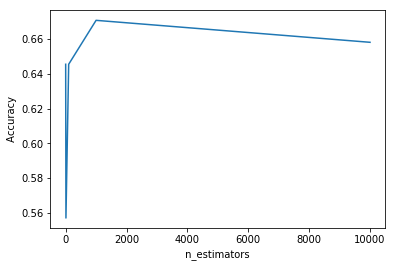

In [27]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='entropy', max_depth=100)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6962025316455697, with max_depth = 1000


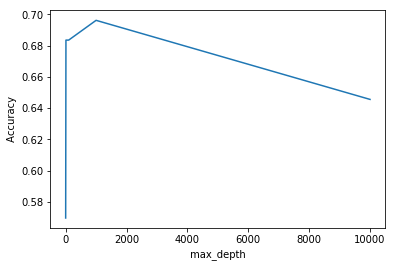

In [28]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='max_depth', criterion='entropy', n_estimators=1000)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6582278481012658, with n_estimators = 1000


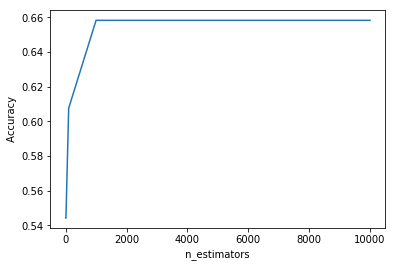

In [29]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='entropy', max_depth=1000)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6455696202531646, with n_estimators = 1000


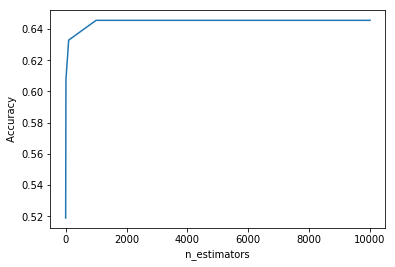

In [30]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='gini', max_depth=1000)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6708860759493671, with max_depth = 10


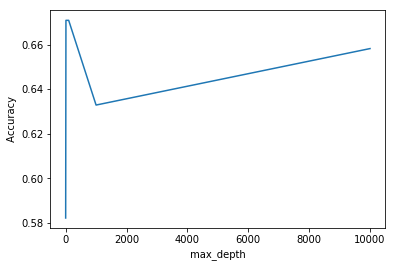

In [32]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='max_depth', criterion='gini', n_estimators=1000)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7468354430379747, with n_estimators = 10


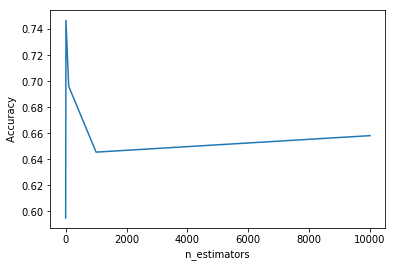

In [34]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='gini', max_depth=10)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7341772151898734, with max_depth = 1


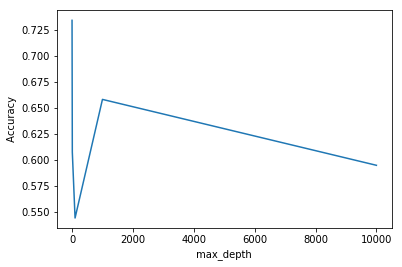

In [35]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='max_depth', criterion='gini', n_estimators=10)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.5949367088607594, with n_estimators = 1000


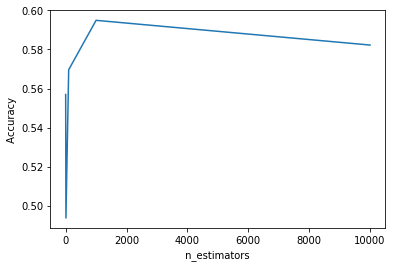

In [36]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='gini', max_depth=1)

Progress = 10.0%
Progress = 20.0%
Progress = 30.0%
Progress = 40.0%
Progress = 50.0%
Progress = 60.0%
Progress = 70.0%
Progress = 80.0%
Progress = 90.0%
Progress = 100.0%
max_acc = 0.6708860759493671, with max_depth = 5


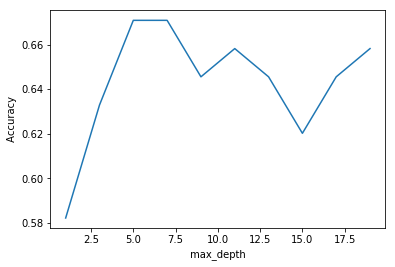

In [37]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 20, 2), model=RandomForestClassifier()
                , title='max_depth', criterion='gini', n_estimators=1000)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.6708860759493671, with n_estimators = 1000


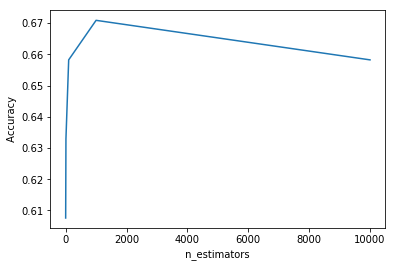

In [38]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=RandomForestClassifier()
                , title='n_estimators', criterion='gini', max_depth=5)

### Result : n_estimators = 1000,  criterion='gini', max_depth=5

### GradientBoostingClassifier

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7215189873417721, with n_estimators = 100


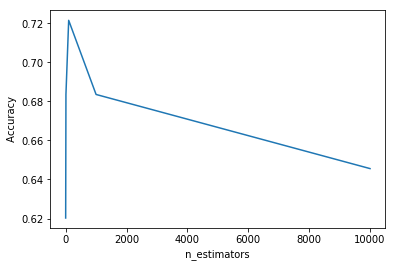

In [39]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=GradientBoostingClassifier()
                , title='n_estimators', learning_rate=0.1, max_depth=3)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7088607594936709, with max_depth = 1


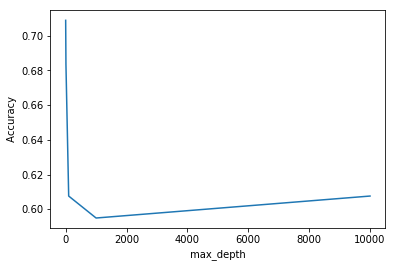

In [40]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=GradientBoostingClassifier()
                , title='max_depth', learning_rate=0.1, n_estimators=100)

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7088607594936709, with max_depth = 1


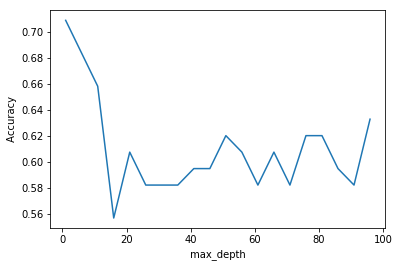

In [41]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 5), model=GradientBoostingClassifier()
                , title='max_depth', learning_rate=0.1, n_estimators=100)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.7468354430379747, with learning_rate = 1


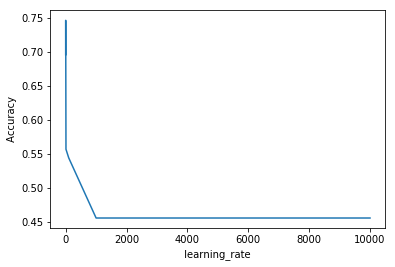

In [43]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=GradientBoostingClassifier()
                , title='learning_rate', max_depth=1, n_estimators=100)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7468354430379747, with max_depth = 1


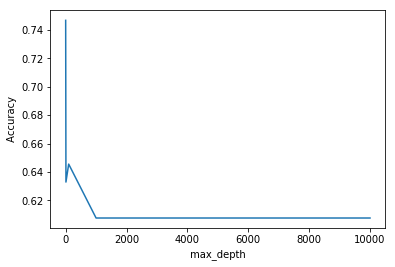

In [44]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=GradientBoostingClassifier()
                , title='max_depth', learning_rate=1, n_estimators=100)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7468354430379747, with n_estimators = 100


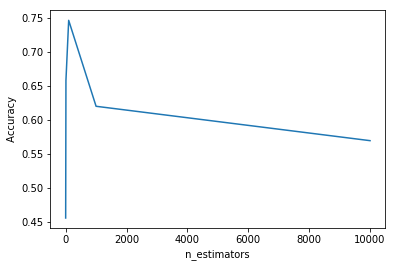

In [47]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=GradientBoostingClassifier()
                , title='n_estimators', learning_rate=1, max_depth=1)

### Result : learning_rate=1, max_depth=1, n_estimators = 100


### LGBMClassifier

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7215189873417721, with n_estimators = 100


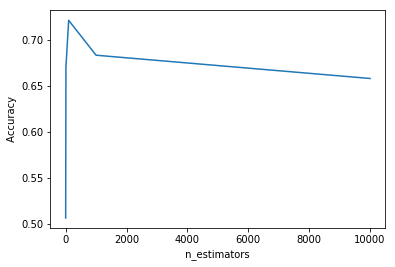

In [46]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=LGBMClassifier()
                , title='n_estimators', learning_rate=1, max_depth=1)

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7341772151898734, with max_depth = 10


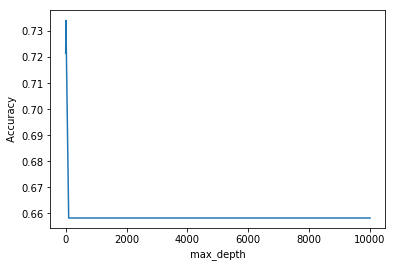

In [48]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 10, 100, 1000, 10000], model=LGBMClassifier()
                , title='max_depth', learning_rate=1, n_estimators=100) 

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.759493670886076, with n_estimators = 1000


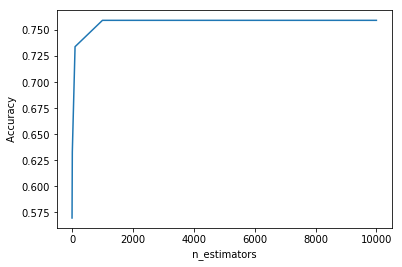

In [49]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=LGBMClassifier()
                , title='n_estimators', learning_rate=1, max_depth=10)

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.6835443037974683, with max_depth = 1


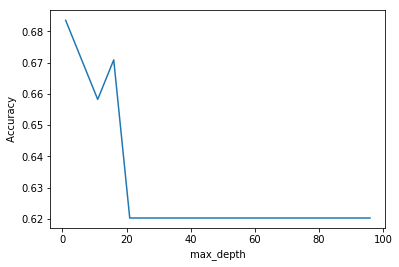

In [51]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 5), model=LGBMClassifier()
                , title='max_depth', learning_rate=1, n_estimators=1000) 

Progress = 2.564102564102564%
Progress = 5.128205128205128%
Progress = 7.6923076923076925%
Progress = 10.256410256410255%
Progress = 12.82051282051282%
Progress = 15.384615384615385%
Progress = 17.94871794871795%
Progress = 20.51282051282051%
Progress = 23.076923076923077%
Progress = 25.64102564102564%
Progress = 28.205128205128204%
Progress = 30.76923076923077%
Progress = 33.33333333333333%
Progress = 35.8974358974359%
Progress = 38.46153846153847%
Progress = 41.02564102564102%
Progress = 43.58974358974359%
Progress = 46.15384615384615%
Progress = 48.717948717948715%
Progress = 51.28205128205128%
Progress = 53.84615384615385%
Progress = 56.41025641025641%
Progress = 58.97435897435898%
Progress = 61.53846153846154%
Progress = 64.1025641025641%
Progress = 66.66666666666666%
Progress = 69.23076923076923%
Progress = 71.7948717948718%
Progress = 74.35897435897436%
Progress = 76.92307692307693%
Progress = 79.48717948717949%
Progress = 82.05128205128204%
Progress = 84.61538461538461%
Progres

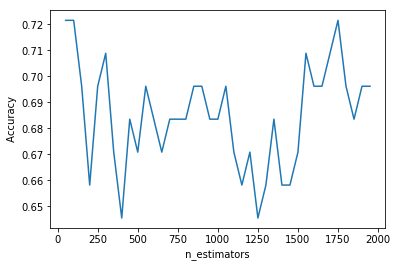

In [53]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(50, 2000, 50), model=LGBMClassifier()
                , title='n_estimators', learning_rate=1, max_depth=1)

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7215189873417721, with max_depth = 1


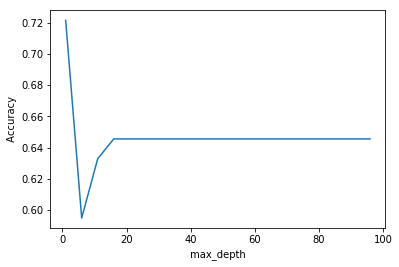

In [54]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 5), model=LGBMClassifier()
                , title='max_depth', learning_rate=1, n_estimators=50) 

Progress = 4.0%
Progress = 8.0%
Progress = 12.0%
Progress = 16.0%
Progress = 20.0%
Progress = 24.0%
Progress = 28.000000000000004%
Progress = 32.0%
Progress = 36.0%
Progress = 40.0%
Progress = 44.0%
Progress = 48.0%
Progress = 52.0%
Progress = 56.00000000000001%
Progress = 60.0%
Progress = 64.0%
Progress = 68.0%
Progress = 72.0%
Progress = 76.0%
Progress = 80.0%
Progress = 84.0%
Progress = 88.0%
Progress = 92.0%
Progress = 96.0%
Progress = 100.0%
max_acc = 0.7088607594936709, with learning_rate = 0.05


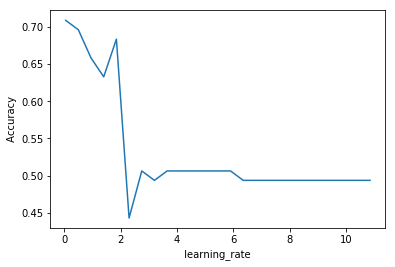

In [57]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(5, 1100, 45)], model=LGBMClassifier()
                , title='learning_rate', max_depth=1, n_estimators=50) 

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7215189873417721, with max_depth = 16


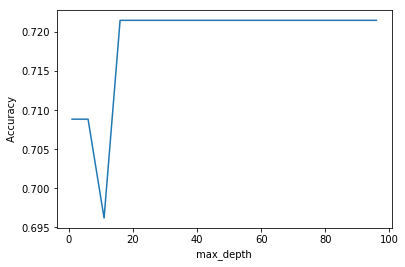

In [58]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 5), model=LGBMClassifier()
                , title='max_depth', learning_rate=0.05, n_estimators=50) 

Progress = 4.0%
Progress = 8.0%
Progress = 12.0%
Progress = 16.0%
Progress = 20.0%
Progress = 24.0%
Progress = 28.000000000000004%
Progress = 32.0%
Progress = 36.0%
Progress = 40.0%
Progress = 44.0%
Progress = 48.0%
Progress = 52.0%
Progress = 56.00000000000001%
Progress = 60.0%
Progress = 64.0%
Progress = 68.0%
Progress = 72.0%
Progress = 76.0%
Progress = 80.0%
Progress = 84.0%
Progress = 88.0%
Progress = 92.0%
Progress = 96.0%
Progress = 100.0%
max_acc = 0.7215189873417721, with learning_rate = 0.05


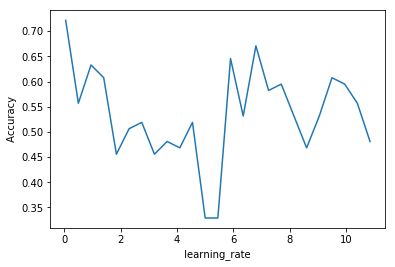

In [59]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(5, 1100, 45)], model=LGBMClassifier()
                , title='learning_rate', max_depth=16, n_estimators=50) 

Progress = 1.0101010101010102%
Progress = 2.0202020202020203%
Progress = 3.0303030303030303%
Progress = 4.040404040404041%
Progress = 5.05050505050505%
Progress = 6.0606060606060606%
Progress = 7.07070707070707%
Progress = 8.080808080808081%
Progress = 9.090909090909092%
Progress = 10.1010101010101%
Progress = 11.11111111111111%
Progress = 12.121212121212121%
Progress = 13.131313131313133%
Progress = 14.14141414141414%
Progress = 15.151515151515152%
Progress = 16.161616161616163%
Progress = 17.17171717171717%
Progress = 18.181818181818183%
Progress = 19.19191919191919%
Progress = 20.2020202020202%
Progress = 21.21212121212121%
Progress = 22.22222222222222%
Progress = 23.232323232323232%
Progress = 24.242424242424242%
Progress = 25.252525252525253%
Progress = 26.262626262626267%
Progress = 27.27272727272727%
Progress = 28.28282828282828%
Progress = 29.292929292929294%
Progress = 30.303030303030305%
Progress = 31.313131313131315%
Progress = 32.323232323232325%
Progress = 33.3333333333333

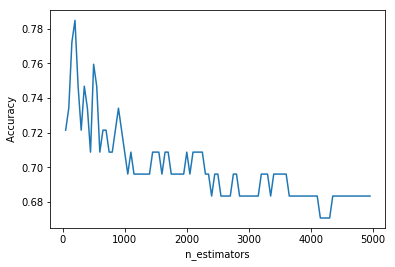

In [60]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(50, 5000, 50), model=LGBMClassifier()
                , title='n_estimators', learning_rate=0.05, max_depth=16)

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7848101265822784, with max_depth = 16


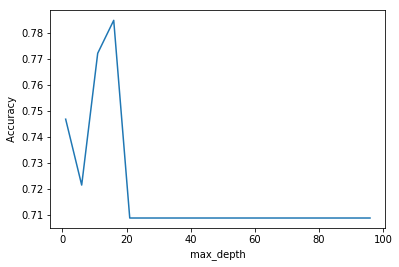

In [63]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=range(1, 100, 5), model=LGBMClassifier()
                , title='max_depth', learning_rate=0.05, n_estimators=200) 

Progress = 4.0%
Progress = 8.0%
Progress = 12.0%
Progress = 16.0%
Progress = 20.0%
Progress = 24.0%
Progress = 28.000000000000004%
Progress = 32.0%
Progress = 36.0%
Progress = 40.0%
Progress = 44.0%
Progress = 48.0%
Progress = 52.0%
Progress = 56.00000000000001%
Progress = 60.0%
Progress = 64.0%
Progress = 68.0%
Progress = 72.0%
Progress = 76.0%
Progress = 80.0%
Progress = 84.0%
Progress = 88.0%
Progress = 92.0%
Progress = 96.0%
Progress = 100.0%
max_acc = 0.7848101265822784, with learning_rate = 0.05


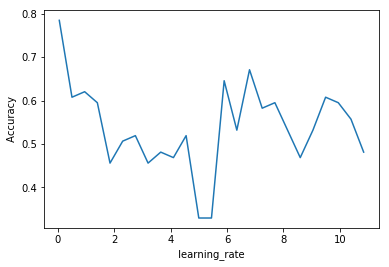

In [64]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(5, 1100, 45)], model=LGBMClassifier()
                , title='learning_rate', max_depth=16, n_estimators=200) 

### Result : max_depth=16, n_estimators=200, learning_rate = 0.05

### AdaBoostClassifier

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.7341772151898734, with learning_rate = 0.1


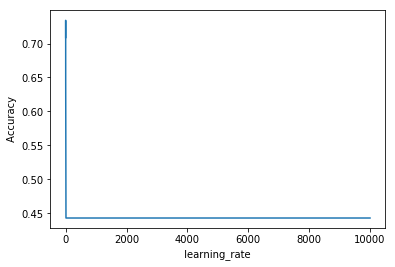

In [65]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000]
                , model=AdaBoostClassifier()
                , title='learning_rate', n_estimators=200) 

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.7468354430379747, with learning_rate = 0.71


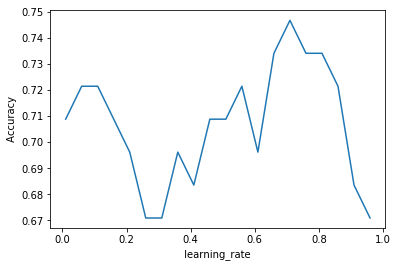

In [66]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(1, 100, 5)]
                , model=AdaBoostClassifier()
                , title='learning_rate', n_estimators=200) 

Progress = 20.0%
Progress = 40.0%
Progress = 60.0%
Progress = 80.0%
Progress = 100.0%
max_acc = 0.7341772151898734, with n_estimators = 100


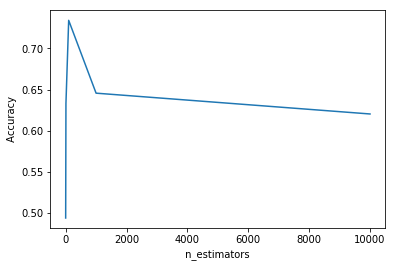

In [67]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000]
                , model=AdaBoostClassifier()
                , title='n_estimators', learning_rate=0.71) 

Progress = 2.0%
Progress = 4.0%
Progress = 6.0%
Progress = 8.0%
Progress = 10.0%
Progress = 12.0%
Progress = 14.000000000000002%
Progress = 16.0%
Progress = 18.0%
Progress = 20.0%
Progress = 22.0%
Progress = 24.0%
Progress = 26.0%
Progress = 28.000000000000004%
Progress = 30.0%
Progress = 32.0%
Progress = 34.0%
Progress = 36.0%
Progress = 38.0%
Progress = 40.0%
Progress = 42.0%
Progress = 44.0%
Progress = 46.0%
Progress = 48.0%
Progress = 50.0%
Progress = 52.0%
Progress = 54.0%
Progress = 56.00000000000001%
Progress = 57.99999999999999%
Progress = 60.0%
Progress = 62.0%
Progress = 64.0%
Progress = 66.0%
Progress = 68.0%
Progress = 70.0%
Progress = 72.0%
Progress = 74.0%
Progress = 76.0%
Progress = 78.0%
Progress = 80.0%
Progress = 82.0%
Progress = 84.0%
Progress = 86.0%
Progress = 88.0%
Progress = 90.0%
Progress = 92.0%
Progress = 94.0%
Progress = 96.0%
Progress = 98.0%
Progress = 100.0%
max_acc = 0.759493670886076, with n_estimators = 181


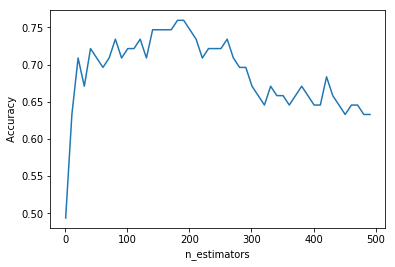

In [68]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(1, 500, 10)
                , model=AdaBoostClassifier()
                , title='n_estimators', learning_rate=0.71) 

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.759493670886076, with learning_rate = 0.71


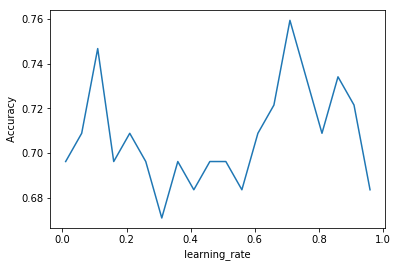

In [69]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(1, 100, 5)]
                , model=AdaBoostClassifier()
                , title='learning_rate', n_estimators=181) 

### Result : n_estimators=181, learning_rate = 0.71